In [1]:
import turtle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error
import sys
# sys.path.append('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils')
# print(sys.path)
# sys.path.remove('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\utils')
from F1tenth_utils import data_preprocess as dp
from F1tenth_utils import plotter_tools
from F1tenth_utils import lift_states
from F1tenth_utils import plotter_tools_ol
import importlib
importlib.reload(dp)
importlib.reload(plotter_tools)
importlib.reload(plotter_tools_ol)
importlib.reload(lift_states)

import scipy as sc

# Modules from core and koopman core
from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import dubins_car_sys


C:\Users\ajoglek\AppData\Local\Temp\ipykernel_11240\1406058241.py:23: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [2]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

In [3]:
# Call the utils function for data pre-processing
X_train, U_train, T_diff_states,T_diff_inputs = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Train')
X_test, U_test, T_diff_states_test,T_diff_inputs_test = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Test')

18.875739746093746


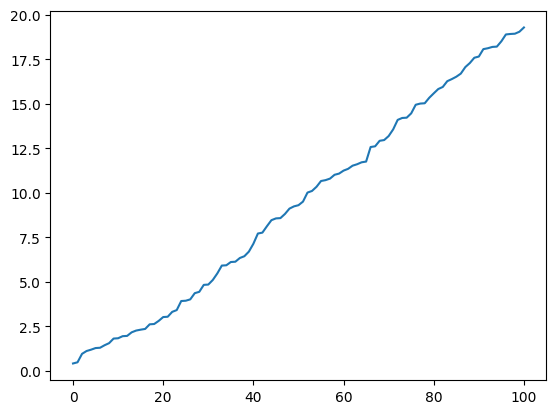

In [89]:
print(T_diff_states[5][-1] - T_diff_states[5][0])
plt.plot(T_diff_states[5])

[0]


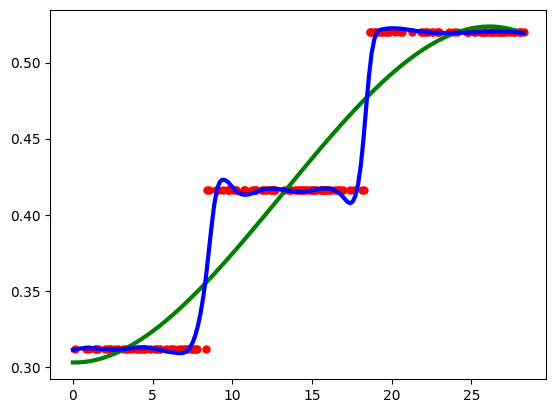

(167,)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
num = np.random.randint(0,len(X_train),1)
num = [0]
print(num)
U = U_train[num[0]][1:,1].T
T = T_diff_inputs[num[0]]
plt.plot(T, U, 'ro', ms=5)

spl = UnivariateSpline(T, U)
xs = np.linspace(0,T_diff_states[num[0]][-1], len(T_diff_inputs[num[0]]))
plt.plot(xs, spl(xs), 'g', lw=3)

spl.set_smoothing_factor(0.01)
plt.plot(xs, spl(xs), 'b', lw=3)
plt.show()

print(spl(xs).shape)

[Text(0, 0.5, '$\\phi$'), Text(0.5, 0, '$t$')]

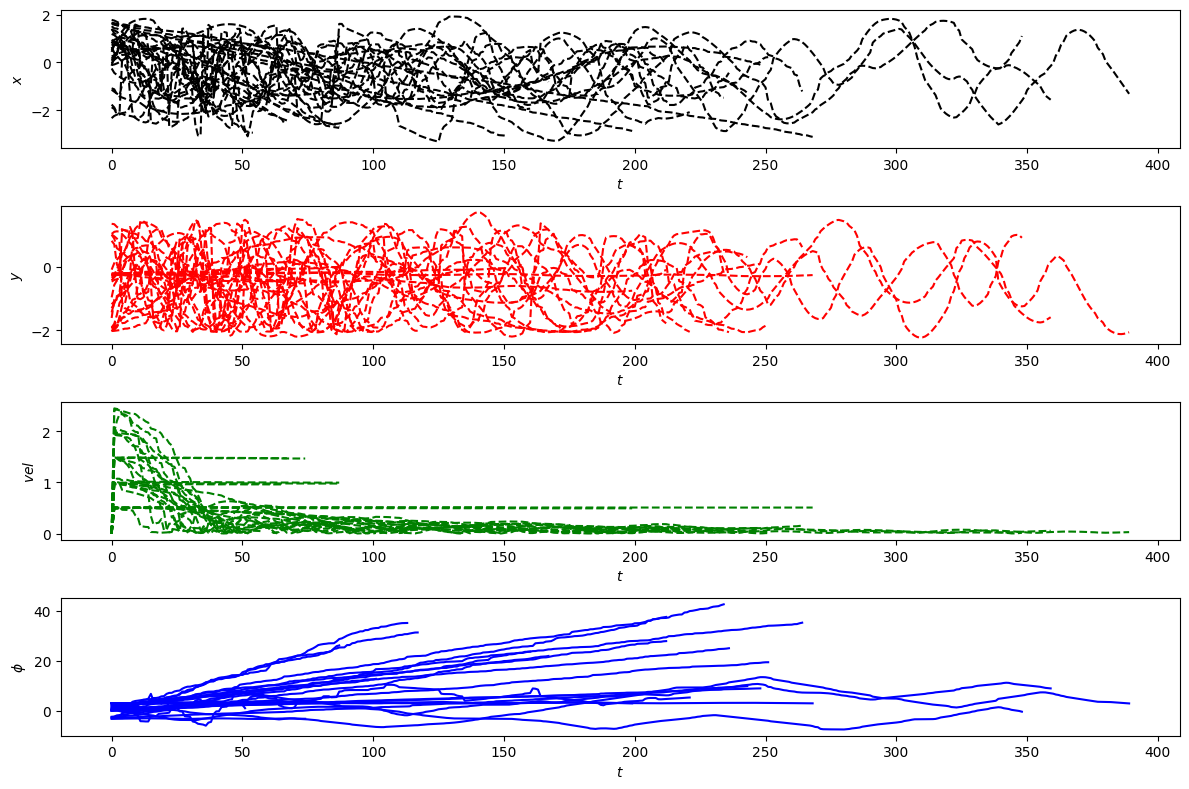

In [4]:
# Plot the data
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
for i in range(len(X_train) - 3):
    x = X_train[i][:,0]
    y = X_train[i][:,1]
    phi = X_train[i][:,3]
    vel = X_train[i][:,2]
    delta = U_train[i][:,1]
    axs[0].plot(x, '--k')
    axs[1].plot(y, '--r')
    axs[2].plot(vel, '--g')
    axs[3].plot(phi, '-b')
    # axs[4].plot(delta, 'm')
axs[0].set(
        ylabel=r'$x$',
        xlabel=r'$t$')
axs[1].set(
        ylabel=r'$y$',
        xlabel=r'$t$')
axs[2].set(
        ylabel=r'$vel$',
        xlabel=r'$t$')
axs[3].set(
        ylabel=r'$\phi$',
        xlabel=r'$t$')

In [5]:
def EDMD_koopman(X0,U):
    X0 = np.vstack(X0) # Vertical stack of data runs
    U0 = np.vstack(U)
    # Get temporally shifted data matrix
    X = X0[:-1,:]
    Y = X0[1:,:]

    # Lifting of states
    X_lift = lift_states.lift_states(X)
    Y_lift = lift_states.lift_states(Y)
    zt = X_lift
    zt_plus1 = Y_lift
    zt_control = np.row_stack((X_lift,U0.T)) # Stacking for left shifted control matrix
    print('Array shapes of zt, zt+1 and zt_control are',zt.shape,zt_plus1.shape,zt_control.shape)

    # Koopman A and B matrix by EDMD
    A_B = zt_plus1@zt_control.T@np.linalg.pinv(zt_control@zt_control.T) # Analytical solution for data snapshots
    A_edmd = np.round(A_B[:,:-2],4) # Get A matrix baring the last two columns for control matrix rounded
    B_edmd = np.round(A_B[:,-2:],4) # Get B matrix with the last two columns for control matrix rounded
    print(np.linalg.pinv(zt).shape)
    C_edmd =  np.round(X0.T@np.linalg.pinv(zt))
    return A_B,A_edmd,B_edmd, C_edmd

In [6]:
# Lift the system analytically to get A,B,C matrix from X_train data
from numpy import linalg as LA
AB, A_edmd, B_edmd, Cedmd =  EDMD_koopman(X_train,U_train)
print(Cedmd)
w, v = LA.eig(A_edmd)
print(AB.shape,A_edmd.shape,B_edmd.shape)

Array shapes of zt, zt+1 and zt_control are (7, 5931) (7, 5931) (9, 5931)
(5931, 7)
[[-0.  1.  0. -0.  0.  0. -0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [-0. -0.  0.  1. -0.  0. -0.]
 [-0. -0.  0.  0.  1.  0.  0.]]
(7, 9) (7, 7) (7, 2)


In [58]:
#Optimization tryouts for the AB matrix using EDMD lifting
# Import packages.
import cvxpy as cp
import numpy as np
from cvxpy.atoms.norm import norm

# Generate data.

X0 = np.vstack(X_train)
U0 = np.vstack(U_train).T
X_t = lift_states.lift_states(X0)
X_opt = X_t[:,:-1]
Y_opt = X_t[:,1:]


# Define and solve the CVXPY problem.
A_edmd_fro = cp.Variable((X_t.shape[0],X_t.shape[0]))
B_edmd_fro = cp.Variable((X_t.shape[0],2))
cost_in_fro = norm((Y_opt - A_edmd_fro @ X_opt -B_edmd_fro @ U0),'fro')
# cost = norm(Y_opt - A @ X_opt -B @ U0)
prob = cp.Problem(cp.Minimize(cost_in_fro))
prob.solve(solver=cp.SCS)

A_edmd_fro = np.array(A_edmd_fro.value)
B_edmd_fro = np.array(B_edmd_fro.value)

if A_edmd.all() == A_edmd_fro.all():
    print('WTF')
# # Print result.
# print("\nThe optimal value is", prob.value)
# print("The optimal x is")
# print(A.value,B.value)

In [74]:
run_name = 'Training runs'
imsave_name = 'Koopman_edmd_training_prediction_ol'
plotter_tools_ol.plot_lifted_predictions(X_train,A_edmd_fro,B_edmd_fro,U_train,run_name)

(7, 7) (7, 2) (7, 244) (2, 244)
(7, 7) (7, 2) (7, 168) (2, 168)
(7, 7) (7, 2) (7, 235) (2, 235)
(7, 7) (7, 2) (7, 187) (2, 187)
(7, 7) (7, 2) (7, 249) (2, 249)
(7, 7) (7, 2) (7, 102) (2, 102)
(7, 7) (7, 2) (7, 252) (2, 252)
(7, 7) (7, 2) (7, 237) (2, 237)
(7, 7) (7, 2) (7, 213) (2, 213)
(7, 7) (7, 2) (7, 161) (2, 161)
(7, 7) (7, 2) (7, 118) (2, 118)
(7, 7) (7, 2) (7, 114) (2, 114)
(7, 7) (7, 2) (7, 88) (2, 88)
(7, 7) (7, 2) (7, 265) (2, 265)
(7, 7) (7, 2) (7, 213) (2, 213)
(7, 7) (7, 2) (7, 152) (2, 152)
(7, 7) (7, 2) (7, 269) (2, 269)
(7, 7) (7, 2) (7, 55) (2, 55)
(7, 7) (7, 2) (7, 200) (2, 200)
(7, 7) (7, 2) (7, 88) (2, 88)
(7, 7) (7, 2) (7, 88) (2, 88)
(7, 7) (7, 2) (7, 67) (2, 67)
(7, 7) (7, 2) (7, 68) (2, 68)
(7, 7) (7, 2) (7, 75) (2, 75)
(7, 7) (7, 2) (7, 52) (2, 52)
(7, 7) (7, 2) (7, 390) (2, 390)
(7, 7) (7, 2) (7, 349) (2, 349)
(7, 7) (7, 2) (7, 59) (2, 59)
(7, 7) (7, 2) (7, 222) (2, 222)
(7, 7) (7, 2) (7, 360) (2, 360)
(7, 7) (7, 2) (7, 278) (2, 278)
(7, 7) (7, 2) (7, 264) (2,

KeyboardInterrupt: 

(7, 7) (7, 2) (7, 259) (2, 259)
(7, 7) (7, 2) (7, 267) (2, 267)
(7, 7) (7, 2) (7, 251) (2, 251)
(7, 7) (7, 2) (7, 179) (2, 179)
(7, 7) (7, 2) (7, 87) (2, 87)
(7, 7) (7, 2) (7, 258) (2, 258)
(7, 7) (7, 2) (7, 143) (2, 143)
(7, 7) (7, 2) (7, 223) (2, 223)
(7, 7) (7, 2) (7, 123) (2, 123)
(7, 7) (7, 2) (7, 228) (2, 228)
(7, 7) (7, 2) (7, 67) (2, 67)
(7, 7) (7, 2) (7, 61) (2, 61)
(7, 7) (7, 2) (7, 64) (2, 64)
Figure name not provided for save file


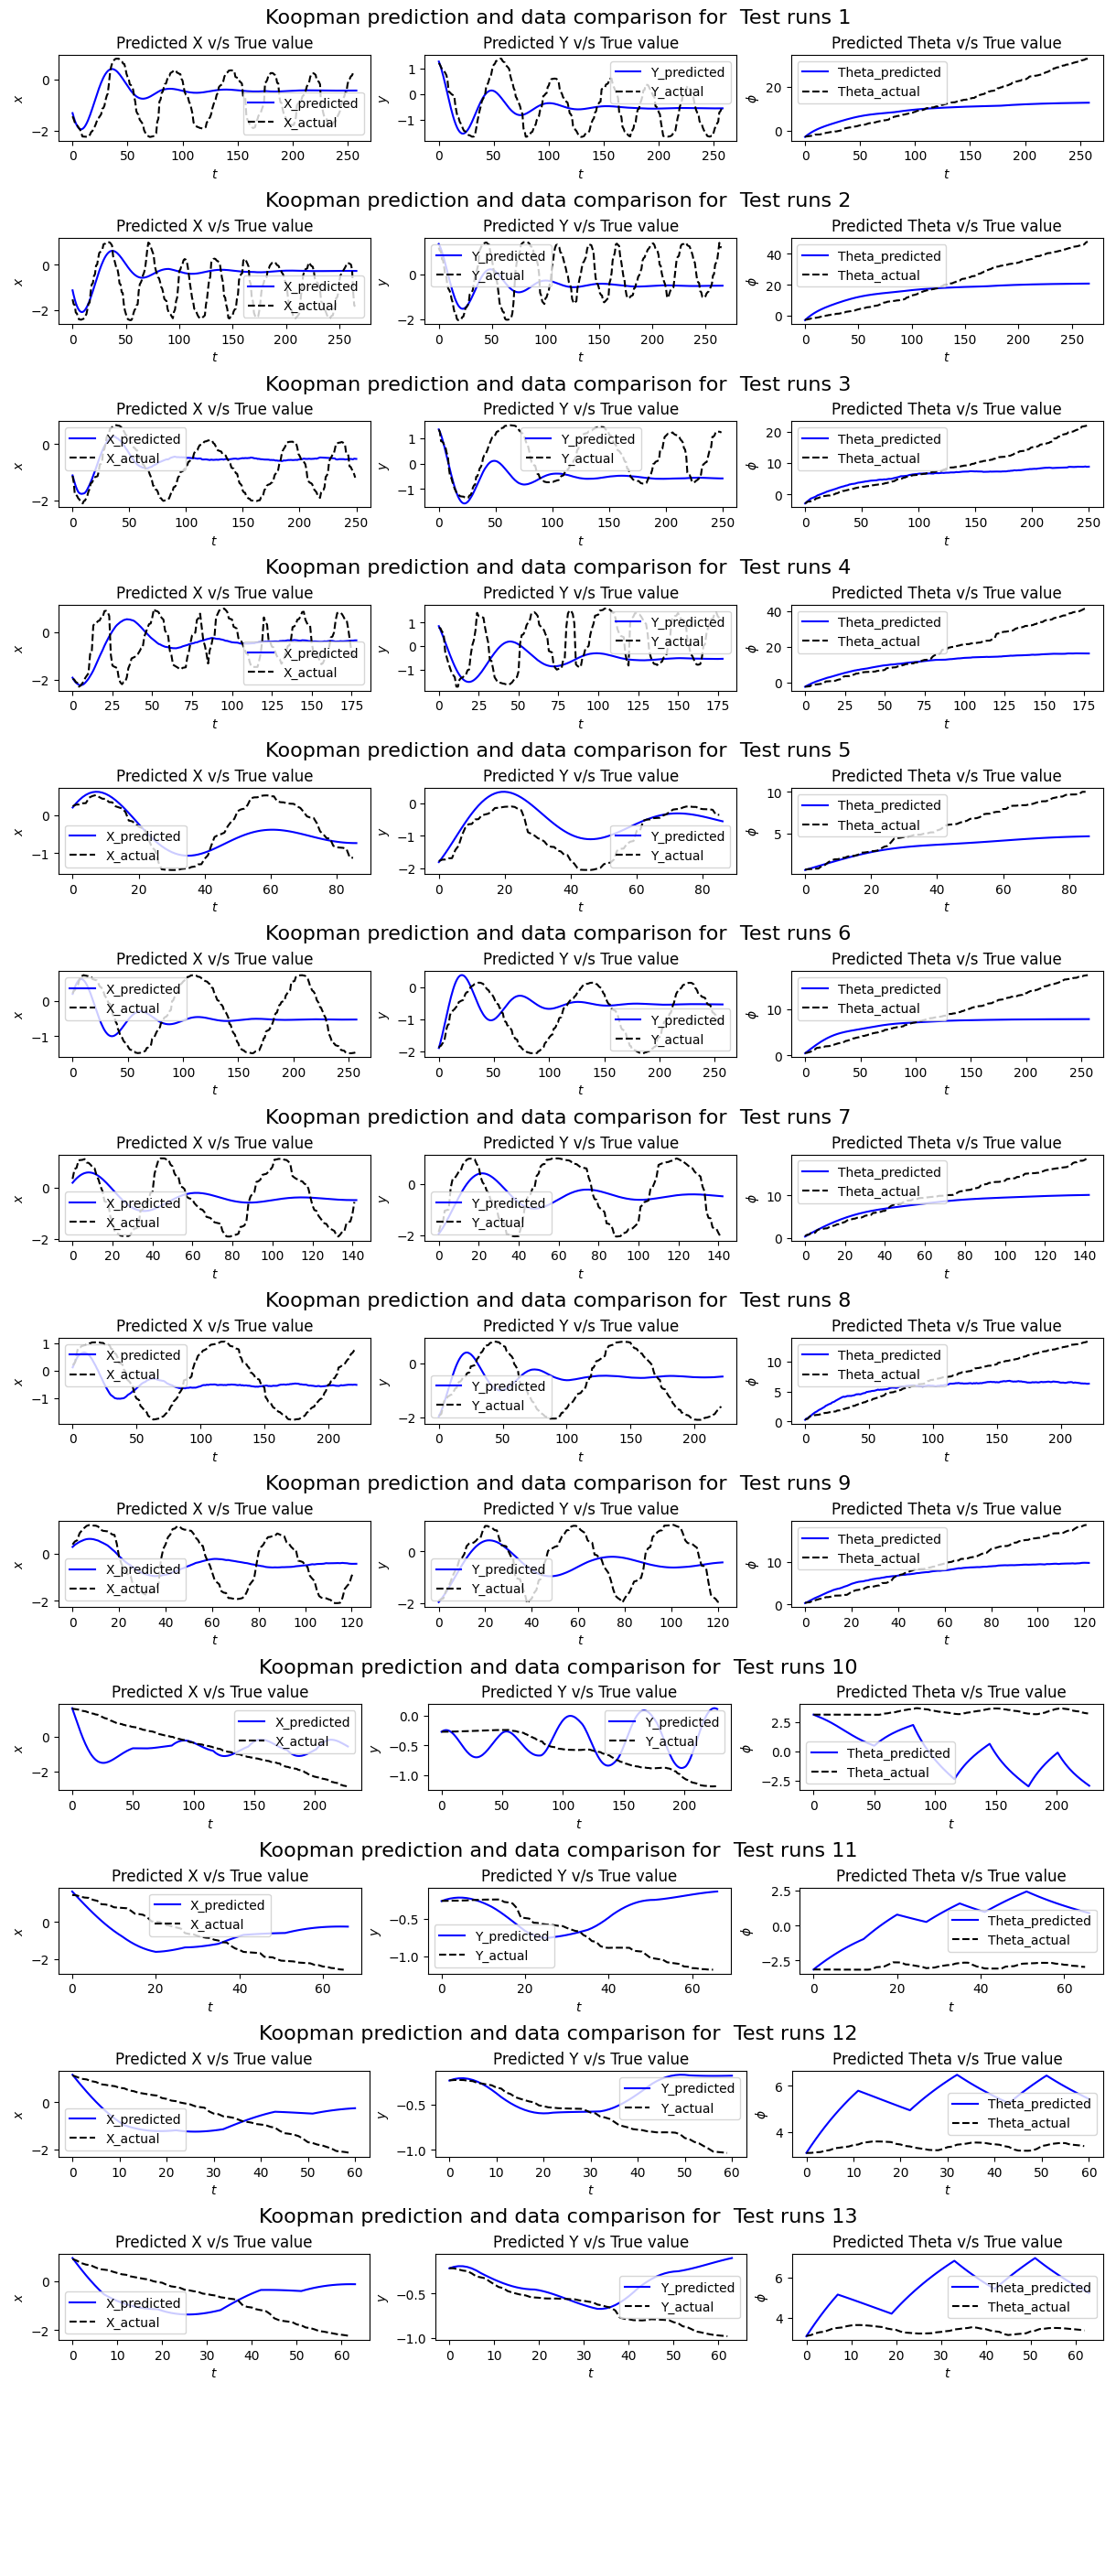

In [8]:
run_name = ' Test runs'
imsave_name = 'Koopman_edmd_testing_prediction'
plotter_tools_ol.plot_lifted_predictions(X_test,A_edmd,B_edmd,U_test,run_name)

In [38]:
def simulate_ol(A,B,C,X,u):
    zt = lift_states.lift_states(X)
    u = u.T
    # print(u.shape)
    z_prime = np.zeros((A.shape[0],u.shape[1]))
    z_prime[:,0] = zt[:,0]
    z_prime_2 = np.zeros((A.shape[0],u.shape[1]))
    x_hat = []
    x_hat.append(X[0,:])
    # print(x_hat[-1])
    # print(zt.shape,u.shape)
    for i in range(1,u.shape[1]):
            # # x_t = x_hat[:,i-1]
            z_prime[:,i] = A@z_prime[:,i-1] + B@u[:,i-1]

            # print(test_.shape)
            # print(test_)
            # print(test_.shape)

            # print(z_prime_2)
            # break
            # break
            # z_prime_2[:,i]
            x_hat_ = C@z_prime[:,i]
            # x_t_1 = x_t +x_hat_*0.1
            x_hat.append(x_hat_)

    x_hat = np.vstack(x_hat)



    # fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))

    # axs[0].plot(X[:,0],'b', label='X actual')
    # axs[0].plot(x_hat[:,0],'--r')
    # axs[1].plot(X[:,1],'b', label='Y actual')
    # axs[1].plot(x_hat[:,1],'--r')
    # axs[2].plot(X[:,3],'b', label='Theta actual')
    # axs[2].plot(x_hat[:,3],'--r')


    return x_hat

In [27]:
num = np.random.randint(0,len(X_test),1)

# print(B_edmd.shape,B_edmd_fro.shape)
# print(num)
x_hat_test = simulate_ol(A_edmd_fro,B_edmd_fro,Cedmd,X_test[num[0]],U_test[num[0]])

[2]


Loading...: 100%|██████████| 231/231 [00:19<00:00, 11.83it/s]

(2, 251)
(251, 4)


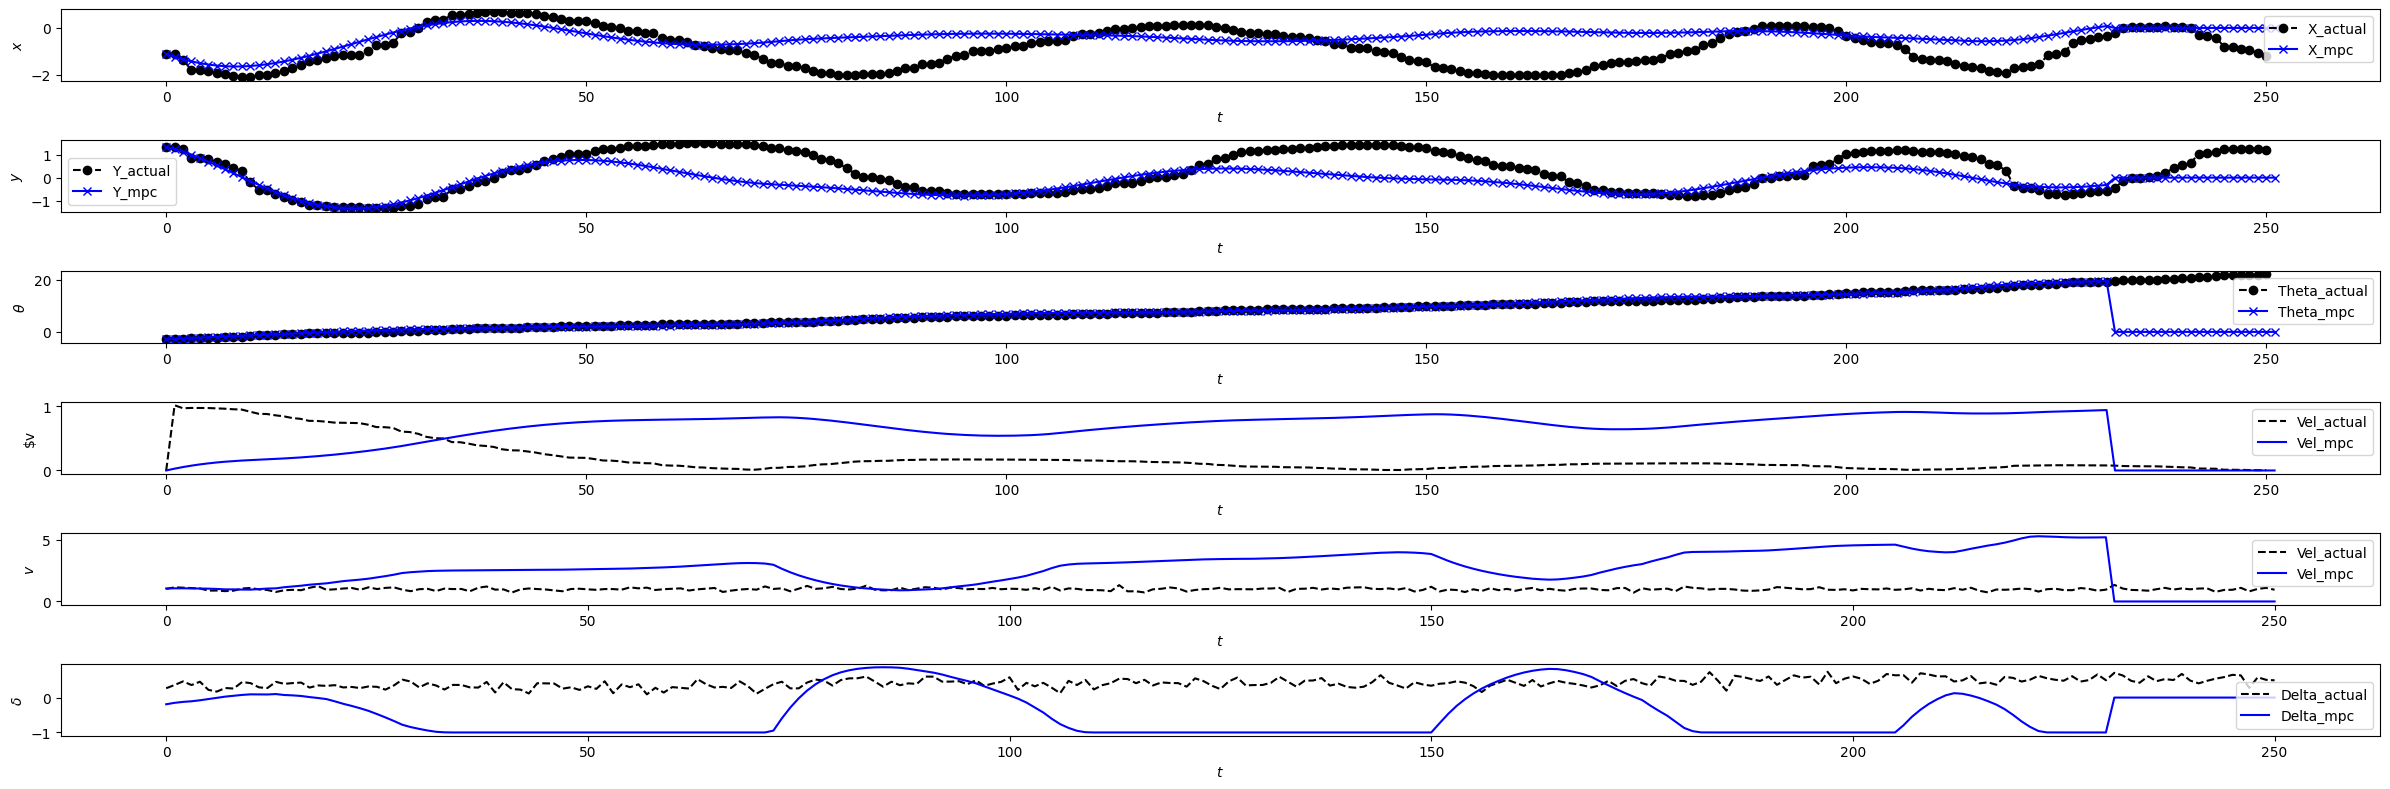

In [52]:
# Linear MPC with cvxpy
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
from tqdm import tqdm
import time
num = np.random.randint(0,len(X_test),1)
# num = [2]
print(num)
# Initialization
x_ref = X_test[num[0]]
z_ref = lift_states.lift_states(x_ref)
u_ref = U_test[num[0]].T
N = 20 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1]))
z_init[:,0] = z_ref[:,0]

u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1]))


Q = np.zeros((z_ref.shape[0],z_ref.shape[0]))
R = np.eye(2)
Q[1,1] = 1 ; Q[2,2] = 1; Q[3,3] = 0.2; Q[4,4] = 0.1
umin = np.array([-1,-1]).reshape(2)
umax = np.array([10,1]).reshape(2)
count = 1
time_count = []


for count in tqdm(range(1,z_ref.shape[1] - N),desc="Loading..."): # Main loop for solver
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N])
    # print(z_ref_.shpe,u_ref_.shape)
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constaint value
    for i in range(N):
        # print(i)
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(15,1)) - z_ref_[:,i+1],Q) + cp.quad_form(reshape(u_pred[:,i],(2,1)) - u_ref_[:,i],R) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(15,1)) - z_ref_[:,i+1],Q)  # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        if i == 0:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        else:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) + cp.quad_form(reshape((u_pred[:,i]-u_pred[:,i-1])/0.5,(2,1)) ,np.eye(2)*2) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        constr += [z_pred[:, i + 1] == A_edmd_fro @ z_pred[:, i] + B_edmd_fro @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        # except:
        #     print('Dimension mismatch')
    # sums problem objectives and concatenates constraints.
    constr += [z_pred[:, 0] == z_init[:,count-1]]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose=False)
    # print(problem.solve())
    u_mpc[:,count-1] = u_pred.value[:,0]
    z_init[:,count] = A_edmd_fro@z_init[:,count-1] + B_edmd_fro@u_pred.value[:,0]
    # z_init[:,count] = reshape(z_ref_[:,0],(15,1))
    # count += 1
    # t1 = time.time()
    # t_diff = t1-t0
    # time_count.append(t_diff)


# plt.plot(time_count)
print(u_mpc.shape)
#Get open loop response
x_hat_ol = simulate_ol(A_edmd_fro,B_edmd_fro,Cedmd,X_test[num[0]],U_test[num[0]])
print(x_hat_ol.shape)

#Plot all
fig, axs = plt.subplots(6, 1, tight_layout=True, figsize=(24, 8))
# axs[0].plot(y[4,:], '--r')
axs[0].plot(X_test[num[0]][:,0],'--k', label='X actual',marker='o')
axs[0].plot(z_init[1,:],'b',label='X mpc',marker='x')
# axs[0].plot(x_hat_ol[:,0],'g',label='X ol')
axs[0].set(ylabel=r'$x$',xlabel=r'$t$')
axs[0].legend(['X_actual','X_mpc','X_ol'])

# test = np.arange(0,X_test[num[0]].shape[0])
# print(test)
axs[1].plot(X_test[num[0]][:,1],'--k', label='Y actual',marker='o')
axs[1].plot(z_init[2,:],'b',label='Y mpc',marker='x')
# axs[1].plot(x_hat_ol[:,1],'g',label='Y ol')
axs[1].set(ylabel=r'$y$',xlabel=r'$t$')
axs[1].legend(['Y_actual','Y_mpc','Y_ol'])


axs[2].plot(X_test[num[0]][:,3],'--k', label='Theta actual',marker='o')
axs[2].plot(z_init[4,:],'b',label='Theta mpc',marker='x')
# axs[2].plot(x_hat_ol[:,3],'g',label='Theta ol')
axs[2].set(ylabel=r'$\theta$',xlabel=r'$t$')
axs[2].legend(['Theta_actual','Theta_mpc','Theta_ol'])

axs[3].plot(X_test[num[0]][:,2],'--k', label='V actual')
axs[3].plot(z_init[3,:],'b',label='V mpc')
# axs[2].plot(x_hat_ol[:,3],'g',label='Theta ol')
axs[3].set(ylabel=r'$v',xlabel=r'$t$')
axs[3].legend(['Vel_actual','Vel_mpc','Vel_ol'])



axs[4].plot(U_test[num[0]][:,0],'--k', label='Vel actual')
axs[4].plot(u_mpc[0,:],'b',label='Vel mpc')
axs[4].set(ylabel=r'$v$',xlabel=r'$t$')
axs[4].legend(['Vel_actual','Vel_mpc'])

axs[5].plot(U_test[num[0]][:,1],'--k', label='Delta actual')
axs[5].plot(u_mpc[1,:],'b',label='Delta mpc')
axs[5].set(ylabel=r'$\delta$',xlabel=r'$t$')
axs[5].legend(['Delta_actual','Delta_mpc'])